# Updated telomere calculation with extra bonuses!

In [43]:
import os
import pandas as pd
import seaborn as sns
from telompy import calculate_telomere_lengths
PATH =  r"C:\#BIONANO_DATA\PROBLEMATIC_TELOMER"
GAP_SIZE = 100000

def read_telomeres(path=PATH,gap_size=GAP_SIZE):
    if os.path.isfile("telomere_lengths/telomeres.csv"):
        telomeres_gap = pd.read_csv("telomere_lengths/telomeres.csv")
        return telomeres_gap.drop_duplicates("MoleculeID")
    telomeres_gap = calculate_telomere_lengths(path=path,gap_size=gap_size) #it returns a list -.-
    pd.concat(telomeres,ignore_index=True).to_csv("telomere_lengths/telomeres.csv",index=False)
    return read_telomeres(path=path,gap_size=gap_size)

data = read_telomeres()
display(data['RefContigID'].value_counts().sort_index())
print(data["RefContigID"].value_counts().sum())

1     146
2     175
3     178
4     203
5     124
6     131
7     183
8     136
9     136
10    197
11    155
12    149
13    186
14    164
15    177
16    187
17    193
18    177
19    131
20    120
21     77
Name: RefContigID, dtype: int64

3325


# Explanation of new stuff

We've modified the algo to account for problematic stuff (./Problematic_XXX.ipynb).
For example, when the last label on the reference is NOT the last aligned label on the contig, the algo doesn't work.
We've modified it so that we ignore last label on contig, and only account for the last ALIGNED label on contig.

Then we find all molecules that are aligned to said last ALIGNED label, and we account for position of label that aligns to the last ALIGNED label on contig, and not just starting point. Example:

<span style="color:black">REF: ---------|-------|---------------|----------]</span>

<span style="color:red">CTG: -----------------|---------------|------------|---]</span>

<span style="color:blue">ML1: -----------------|----------------------------|---]</span>

<span style="color:blue">ML2: -----------------|---------------|-------------]</span>

<span style="color:blue">ML3: -----------------|---------------|------------|---]</span>


In the above example, contig (CTG) has extra label after the last label on chromosome. We'll call that LLC (last label contig).
However, the last aligned label on contig (LALC) is actually the second last label.
Molecule 1 aligns to LLC, but does not align to LALC. Molecule 2 aligns to LALC, but does not align to LLC, and Molecule 3 aligns to all 3. In previous algo, we simply used `QryStartPos` or `QryEndPos` to calculate the length, but this does not account for unpaired molecule - this will erroneously use ML1 and ML3. ML1 should not be used (as it does not align to REF's last label via CTG) and it will use **first label** (or the last) position of ML3 instead of **second label** (or the second last).

Now:

<span style="color:black">REF: --------|--------|---------]</span>

<span style="color:red">CTG: --------|--------|---|----------]</span>

<span style="color:blue">ML1: -----------------|---|----|--------|---]</span>

<span style="color:green">TELOMERE: .......|---------------------]</span>


From the above, we can see that we should not look at last (or first) labels, but last aligned labels.
To that extent, we will track:
1. Number of labels on reference that are unpaired (AFTER the last reference-contig pair)
2. Number of labels on contig that are unpaired (AFTER the last refrence-contig pair)
3. Number of labels on molecule that are unpaired (AFTER the last reference-contig par, or its contig-molecule pair)

We can also correct telomeres:

# Telomere Correction

We can see annotations of telomeres, and their exact position via `TableBrowser` on the link: https://genome.ucsc.edu/cgi-bin/hgTables

We set `genome` to Mouse, `assembly` to GRCm38/mm10 (this is our reference), `group` to All Tables, `database` to mm10, then `table` to gap. From `filter` we set it to `type` telomere.

One thing we can see is that there are 2N telomeres - telomeres at the left end of the chromosomes and at the right end of the chromosomes. Telomeres are annotated as gaps, and the `gap size` is set to be 100,000 (10^5). 

The left telomeres start at 0 and end at 10^5. The right telomeres end at end of the chromosome and start at the end of chromosome subtracted for the gap size.

Therefore we can calculate the position of telomeres if we know `gap size`.
We can then correct telomeres. For example:


REF: -------------------|-------x----------]

ML1: -------------------|----|------|----------------]

TEL: ...................|-------x---------------------]

TELC: ..........................x---------------------]


In the above, to get the telomere length we subtract `]` from `|`. But to get actual length we sutract the `x`.
(The difference `]-x` is the gap size)

It's very unlikely that the last label is also the start of chromosome.







# The columns are

## The identity (ID) columns
 - **RefContigID**:
    The chromosome ID.
 - **MoleculeID**:
     The ID of molecule (found in `output/contigs/annotation/refine1_ExperimentLabel/EXP_REFINEFINAL1_contig{x}_q.cmap`)
 - **ContigID**:
     The ID of contig assembled from molecule (found in `output/contigs/annotation/refine1_ExperimentLabel/EXP_REFINEFINAL1_contig{x}.xmap` as `RefContigID` or in  `output/contigs/annotation/exp_refineFinal1_merged.xmap` as `QryContigID`) 
     
## Orientation and Confidence columns
 - **MoleculeOrientation**:
     Orientation of assembly Molecule-Contig
 - **ContigOrientation**:
     Orientation of assembly Contig-Reference
 - **MoleculeConfidence**:
     Confidence of assembly Molecule-Contig
     
## Label Columns
- **UnpairedMoleculeLabels**
    Number of labels after/before the last/first aligned label on the molecule that aligns to the last aligned label on contig that aligns to the last aligned label on the reference.
    
- **UnpairedReferenceLabels**
    Number of labels after last label of the reference that aligns in contig. When there are labels on the reference that do not align with contigs! For example, with chromosome 20 contains 8 labels after last aligned label.

- **UnpairedContigLabels**:
    Number of labels on the contig that are AFTERthe first aligned label of contig to the last label of the Reference to the Reference. For example, in the above example (as well as chrom15 of N22-01/N22-01-11) is one.
     
## TelomereLength columns

- **TelomereLen**:
    Telomere Lengths of molecule as calculated from the formula.
    
- **TelomereLen_corr**:
    Corrected telomere length.
    



In [44]:
display(data['RefContigID'].value_counts().sort_index())
print(data["RefContigID"].value_counts().sum())

1     146
2     175
3     178
4     203
5     124
6     131
7     183
8     136
9     136
10    197
11    155
12    149
13    186
14    164
15    177
16    187
17    193
18    177
19    131
20    120
21     77
Name: RefContigID, dtype: int64

3325


From the above, we can see that we have a bunch molecules, and therefore a bunch of telomeres! 
The formula works. Let's see the number of unpaired labels.


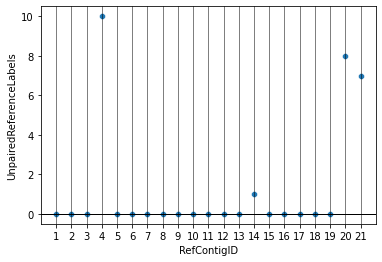

In [45]:
ax = sns.scatterplot(data=data.drop_duplicates(["RefContigID","UnpairedReferenceLabels"]),
              x="RefContigID",y="UnpairedReferenceLabels")
ax.set_xticks(range(1,22))
ax.grid(which='major',axis="x", linestyle='-', linewidth='0.5', color='black',zorder=0)
ax.axhline(0,color="black",lw=1)

There are unpaired ReferenceLabels on chromosomes 4, 14, 20, 21.


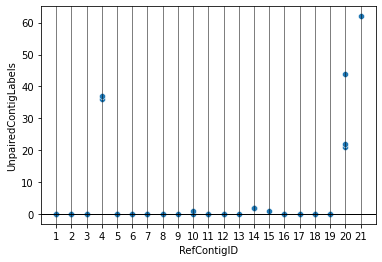

In [46]:
ax = sns.scatterplot(data=data.drop_duplicates(["RefContigID","QryContigID"]),
                x="RefContigID",y="UnpairedContigLabels")
ax.set_xticks(range(1,22))
ax.grid(which='major',axis="x", linestyle='-', linewidth='0.5', color='black',zorder=0)
ax.axhline(0,color="black",lw=1)

There are extra contig labels on chromosome 4, 10, 14, 15, 20, 21.
Of the above, 4, 14,20,21 have unpaired references labels - meaning 10 and 15 have extra contig labels.

### Telomere Lengths!!!

[INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


RefContigID
1      3955
2      1809
3      2265
4      2886
5      2621
6      1559
7      1231
8      3197
9      3999
10     1339
11     1120
12     2494
13     2687
14     2934
15     4264
16     1938
17     1736
18     2654
19     2268
20    12200
21     2571
Name: TelomereLen, dtype: int64

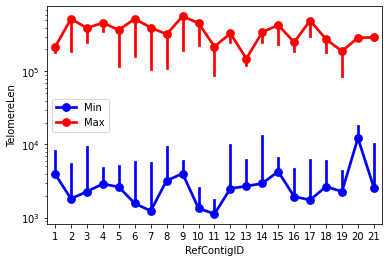

In [47]:
ax = sns.pointplot(x='RefContigID', y='TelomereLen', estimator=min, data=data, color='blue', label='Min')
sns.pointplot(x='RefContigID', y='TelomereLen', estimator=max, data=data, color='red', label='Max',ax=ax)
ax.set_yscale("log")

display(data.groupby("RefContigID")["TelomereLen"].min())
    

Let's do the same for corrected TelomereLength.





[INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


RefContigID
1       3136
2     -11363
3      -8039
4     -53543
5     -11796
6     -49032
7      -6756
8       2778
9        299
10        -8
11       873
12    -15494
13       603
14      1172
15      2112
16      -833
17       643
18      1182
19       524
20    -40834
21   -800900
Name: TelomereLen_corr, dtype: int64

chromosomes with NEGATIVE telomere lengths: [2, 3, 4, 5, 6, 7, 10, 12, 16, 20, 21]
chromosomes with POSITIVE telomere lengths: [1, 8, 9, 11, 13, 14, 15, 17, 18, 19]


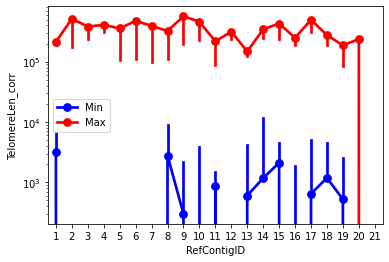

In [48]:
ax = sns.pointplot(x='RefContigID', y='TelomereLen_corr', estimator=min, data=data, color='blue', label='Min')
sns.pointplot(x='RefContigID', y='TelomereLen_corr', estimator=max, data=data, color='red', label='Max',ax=ax)
ax.set_yscale("log")

mintelcorr = data.groupby("RefContigID")["TelomereLen_corr"].min() 
display(mintelcorr)
negative =mintelcorr[mintelcorr<=0].index.to_list()
positive =mintelcorr[mintelcorr>0].index.to_list()

print(f"chromosomes with NEGATIVE telomere lengths: {negative}")

print(f"chromosomes with POSITIVE telomere lengths: {positive}")


<AxesSubplot:xlabel='MoleculeLen', ylabel='TelomereLen_corr'>

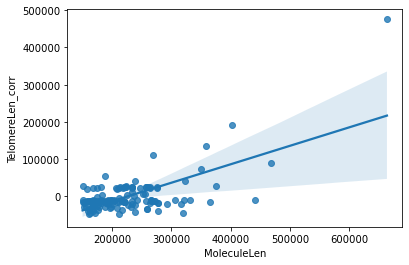

In [61]:
# More specific chromosome

sixer = data.loc[data.RefContigID==6]
sixer['Negative'] = sixer['TelomereLen_corr'] < 0

#lets see if correlation between MolLen and corr

sns.regplot(data=sixer,x="MoleculeLen",y="TelomereLen_corr",)

<AxesSubplot:xlabel='MoleculeLen', ylabel='TelomereLen_corr'>

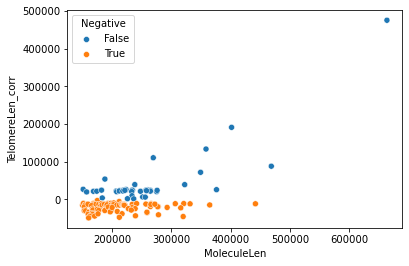

In [63]:
sns.scatterplot(data=sixer,x="MoleculeLen",y="TelomereLen_corr",hue="Negative")

What do negative telomeres mean? If going by the above, it means that the span of molecules AFTER the first label aligns to the last label on reference is smaller than the difference between TelomereStart and LabelStart.

Hmmmm.

In [84]:
just_contigs = data[["RefContigID","QryContigID","AlignedLabelPosition","LastReferencePosition","UnpairedReferenceLabels"]].drop_duplicates(["RefContigID","QryContigID"])

from telompy.funcs import fish_last_label, joinpaths
master_xmap = fish_last_label(joinpaths(PATH))


just_contigs = pd.merge(just_contigs,master_xmap[["RefContigID","RefLen","QryContigID"]],
         left_on=["RefContigID","QryContigID"],right_on=["RefContigID","QryContigID"],
         )
just_contigs["TelomereStart"] = just_contigs["RefLen"] - 100000
just_contigs["Offset"] = just_contigs["AlignedLabelPosition"] - just_contigs["TelomereStart"]

#lets drop those with unpaired reference labels
just_contigs = just_contigs.loc[just_contigs.UnpairedReferenceLabels==0]

above_zero =  data.groupby('RefContigID')['TelomereLen_corr'].apply(lambda x: (x > 0).sum())
below_zero =  data.groupby('RefContigID')['TelomereLen_corr'].apply(lambda x: (x < 0).sum())
above_zero.name = "PositiveTelomeres"
below_zero.name = "NegativeTelomeres"

just_contigs = pd.merge(just_contigs,above_zero,left_on="RefContigID",right_index=True,how="left")

just_contigs = pd.merge(just_contigs,below_zero,left_on="RefContigID",right_index=True,how="left")

display(just_contigs.drop_duplicates(["RefContigID","Offset"]))

,RefContigID,QryContigID,AlignedLabelPosition,LastReferencePosition,UnpairedReferenceLabels,RefLen,TelomereStart,Offset,PositiveTelomeres,NegativeTelomeres
0,1,12,195371152.0,195371152.0,0,195471971.0,195371971.0,-819.0,146,0
2,2,21,182000051.0,182000051.0,0,182113224.0,182013224.0,-13173.0,168,7
4,3,31,159929375.5,159929375.5,0,160039680.0,159939680.0,-10304.5,173,5
8,5,211,151720266.0,151720266.0,0,151834684.0,151734684.0,-14418.0,115,9
10,6,91,149585954.0,149585954.0,0,149736546.0,149636546.0,-50592.0,41,90
12,7,152,145333471.0,145333471.0,0,145441459.0,145341459.0,-7988.0,176,7
14,8,181,129300794.0,129300794.0,0,129401213.0,129301213.0,-419.0,136,0
16,9,62,124491410.0,124491410.0,0,124595110.0,124495110.0,-3700.0,136,0
17,10,51,130593645.0,130593645.0,0,130694993.0,130594993.0,-1348.0,196,1
19,11,71,121982296.0,121982296.0,0,122082543.0,121982543.0,-247.0,155,0


<AxesSubplot:xlabel='Offset', ylabel='PositiveTelomeres'>

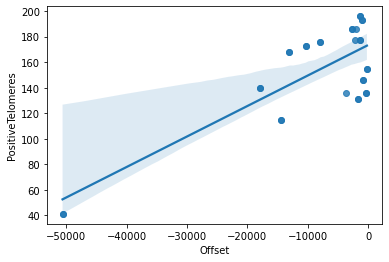

In [87]:
sns.regplot(data=just_contigs,x="Offset",y="PositiveTelomeres")

<AxesSubplot:xlabel='Offset', ylabel='NegativeTelomeres'>

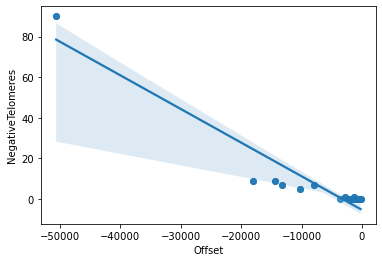

In [88]:
sns.regplot(data=just_contigs,x="Offset",y="NegativeTelomeres")